In [1]:
# Tabular Data
import pandas as pd
import numpy as np

# .py files with custom functions
import wrangle
import explore
import modeling

# suppress warning notifications
import warnings
warnings.filterwarnings("ignore")

# Scaling, clustering, and modeling
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor

# Clustering Project - Estimating LogError in Zillow dataset


## Project Overview and Goals

<div class="alert alert-block alert-success">
<b><font size="+1">The purpose of this project is to create a Regression Model using clustering that predicts the zillow model log error of Single Family Properties that were sold in 2017 from a database of Zillow data.   
<br><br>
    
    
Goal 1: Find drivers of log error in the zillow estimate database
<br>
    Goal 2: Create a model to predict logerror <br>

<hr style="border:10px solid blue">


## Wrangle:  Acquire and Prepare Data

In [2]:
# acquire zillow data
df = wrangle.get_zillow()


In [3]:
# prepare zillow data
df = wrangle.prep_zillow(df)
# remove outliers
df = wrangle.remove_outliers(df)

<div class="alert alert-block alert-success">
<b><font size="+2">Prepare takeaways:  
<br><br>
    
<font size="+1">   
    <u>Missing Data:  </u>  Nulls replaced with zeros<br><br>
    <u>Conversions:  </u>FIPS to county (and one-hot encoded), latitude and logitude put in proper decimal format, year built converted to age, nulls to zeros where appropriate<br><br>
    <u>Removed rows:  </u>Those with remaining null values, rows with invalid zip code, homes with no bedrooms, and homes where the home was larger than the lot<br><br>
    <u>Created columns:  </u>'abserror', the absolute value of logerror; 'dollarspersqft', the taxvalue / the area<br><br>
    <u>Removed outliers:  </u> Rows with values more than 1.5 times the interquartile range from the quartiles were removed

In [4]:
df.head().T

,0,1,2,4,5
parcelid,12826780,17239384,12773139,12768500,12808835
bathrooms,2.0,2.0,1.0,3.0,2.0
bedrooms,3.0,4.0,3.0,4.0,3.0
sqft,1762.0,1612.0,1032.0,1732.0,1116.0
county,Los Angeles,Ventura,Los Angeles,Los Angeles,Los Angeles
latitude,33.937685,34.30014,34.040895,34.044346,34.044604
garagesqft,0.0,560.0,0.0,0.0,0.0
longitude,-117.996709,-118.706327,-118.038169,-118.00292,-117.974827
lotsize,6347.0,12105.0,5074.0,3087.0,6153.0
regionidzip,96171.0,97116.0,96480.0,96490.0,96490.0


In [5]:
df.shape

(46671, 20)

<hr style="border:10px solid blue">


## Data Exploration

### What does our target variable, logerror, look like?

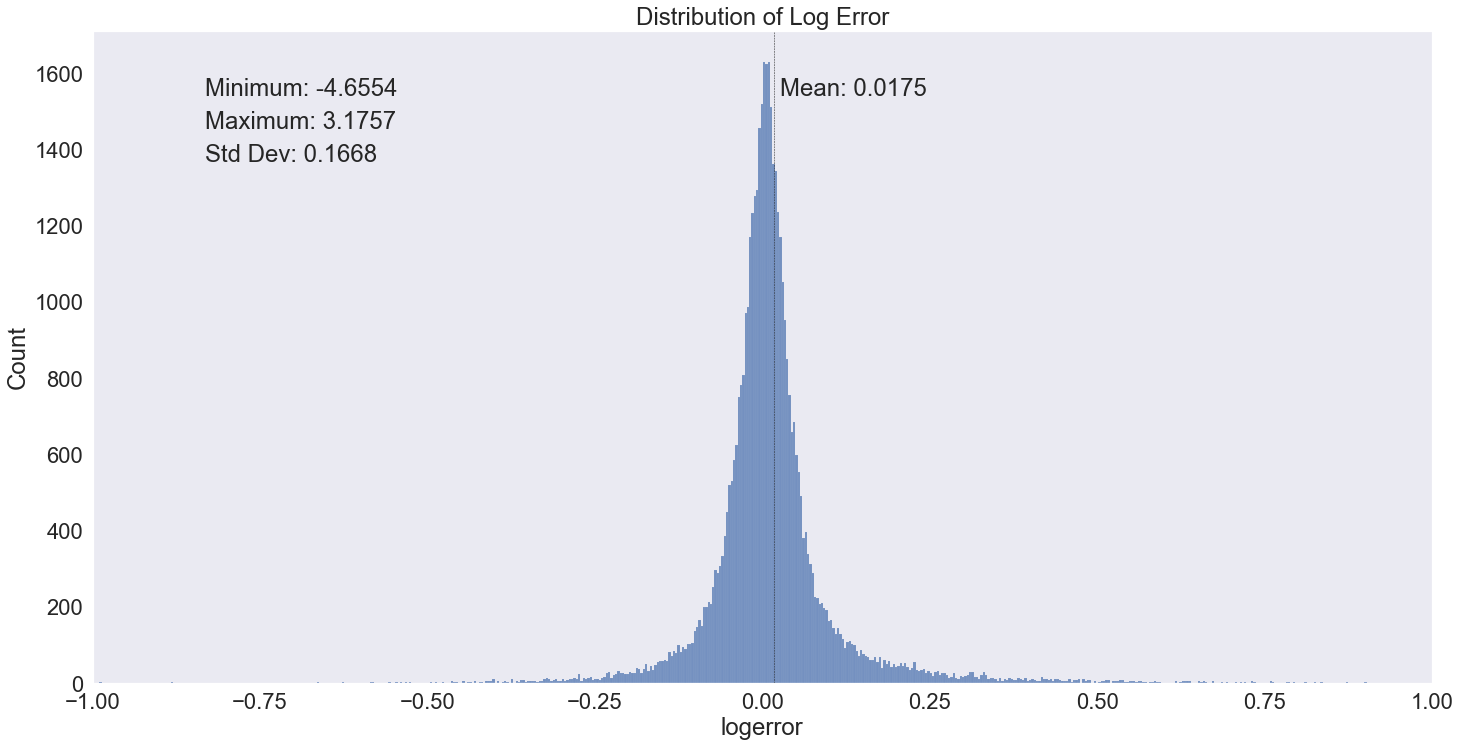

In [6]:
# test target variable distribution plot
explore.target_dist(df)

### Takeaways

- Logerror is normally distributed
- Mean is slightly positive
- Some significant outliers 
- The mean will be close to zero, so will use abserror at times in exploration

In [7]:
### Split data into 60% train, 20% validate, and 20% test
train, validate, test = wrangle.my_split(df)

## Is the Log Error Different in each county?

### H0: Average Log Error of the properties in three counties (Los Angeles, Ventura, and Orange) are all equal.

### Ha: Average Log Error of the properties in three counties (Los Angeles, Ventura, and Orange) are NOT all equal

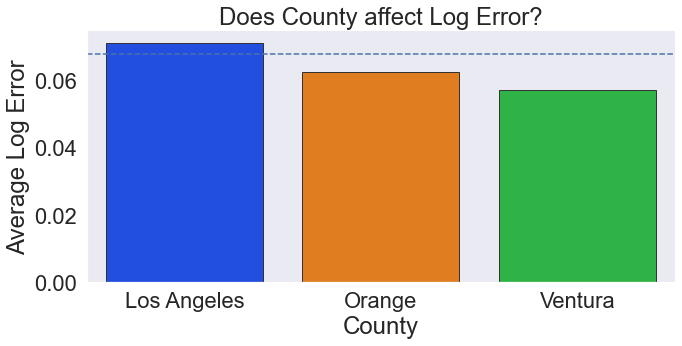

Average logerror of those in Los Angeles County is  0.07
Average logerror value of those in Ventura County is 0.06
Average logerror value of those in Orange County is 0.06


We reject the Null Hypothesis


In [8]:
# plot and perform ANOVA test
explore.county_plot(train)

####  Average Log Error of the properties in three counties (Los Angeles, Ventura, and Orange) are NOT all equal.  There is more error in the predictions in Los Angeles County

## Does lot size impact log error?

### H0: Log Error of small lots is equal to Log Error of all properties

### Ha: Log Error of small lots is significantly different than Log Error of all properties 

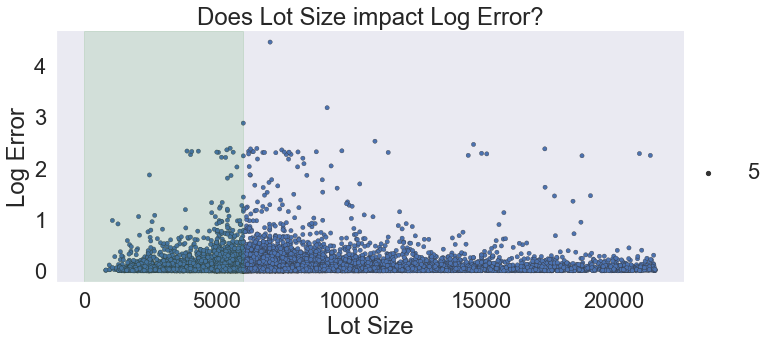

Average logerror of small properties  0.0646
Average logerror of all properties  0.0678


We reject the Null Hypothesis


In [9]:
# plot and perform Independent T-Test
explore.lotsize_plot(train)

####  Average Log Error of small properties is statistically different, but it looks like there may be some optimal ranges for binning or clustering

## Clustering Logitude, Latitude, and Age

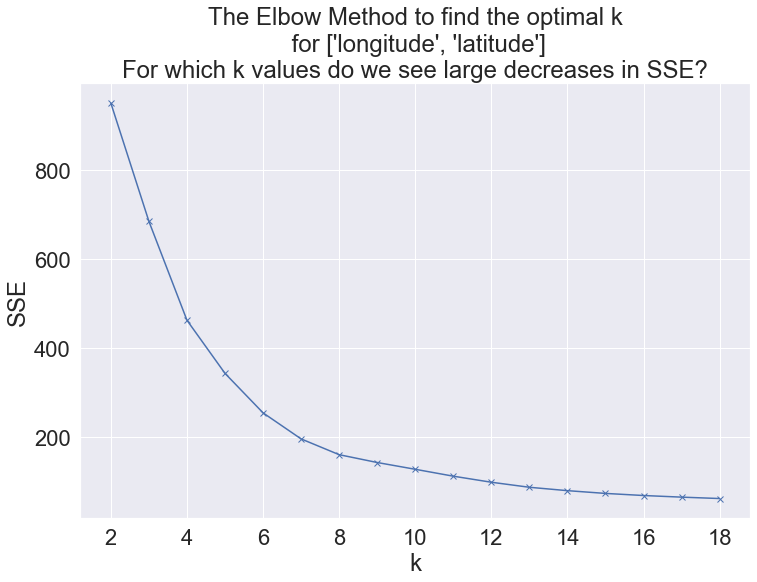

In [10]:
# create features for cluster
cluster_vars = ['longitude','latitude']

# scale data to be used in clustering
scaler = MinMaxScaler()
train[cluster_vars] = scaler.fit_transform(train[cluster_vars])
validate[cluster_vars] = scaler.transform(validate[cluster_vars])
test[cluster_vars] = scaler.transform(test[cluster_vars])


explore.find_k(train, cluster_vars)

### Choose 5 clusters based on elbow method

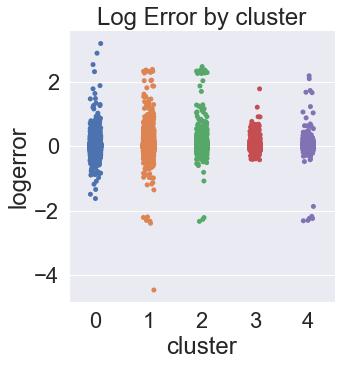

H0:  The logerrors are not significantly different
Ha:  The logerrors are significantly different
We reject the Null Hypothesis


,lat_long,centroid_longitude,centroid_latitude
0,0,0.539287,0.617262
1,1,0.721071,0.436453
2,2,0.875494,0.240620
3,3,0.692114,0.939096
4,4,0.240987,0.654589


In [11]:
# set k and name cluster
k=5
cluster_name = 'lat_long'
# create clusters
kmeans1 = explore.create_clusters(train, k, cluster_vars)

X1_train = train.copy()
X1_train['cluster'] = kmeans1.predict(X1_train[cluster_vars])

explore.cluster_plot(X1_train)
explore.get_centroids(kmeans1, cluster_vars, cluster_name)

#### While there is a statistical difference, No clear groupings seen that would be usefull for modeling  

## Clustering age, sqft, and garagesqft

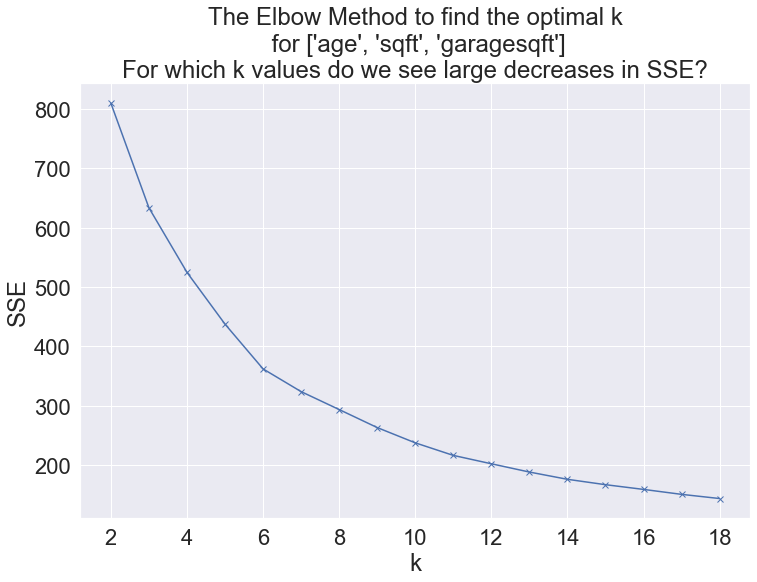

In [12]:
# create features for cluster
cluster_vars = ['age','sqft','garagesqft']

# scale data to be used in clustering
scaler = MinMaxScaler()
train[cluster_vars] = scaler.fit_transform(train[cluster_vars])
validate[cluster_vars] = scaler.transform(validate[cluster_vars])
test[cluster_vars] = scaler.transform(test[cluster_vars])

explore.find_k(train, cluster_vars)

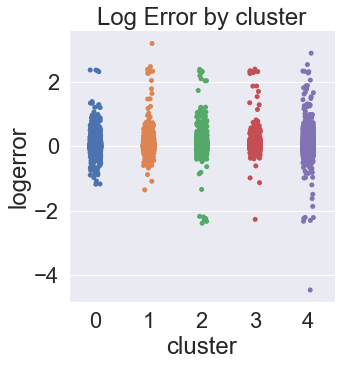

H0:  The logerrors are not significantly different
Ha:  The logerrors are significantly different
We reject the Null Hypothesis


,lot_tax_garage,centroid_age,centroid_sqft,centroid_garagesqft
0,0,0.668045,0.221457,0.006214
1,1,0.426939,0.445255,0.022127
2,2,0.282139,0.296756,0.125621
3,3,0.154214,0.534704,0.134769
4,4,0.456571,0.221073,0.018696


In [13]:
# set k and name cluster
k=5
cluster_name = 'lot_tax_garage'
# create clusters
kmeans2 = explore.create_clusters(train, k, cluster_vars)

X2_train = train.copy()
X2_train['cluster'] = kmeans2.predict(X2_train[cluster_vars])

explore.cluster_plot(X2_train)
explore.get_centroids(kmeans2, cluster_vars, cluster_name)

#### No clear groupings seen to label and utilize centroids despite 

## Clustering lotsize and taxamount

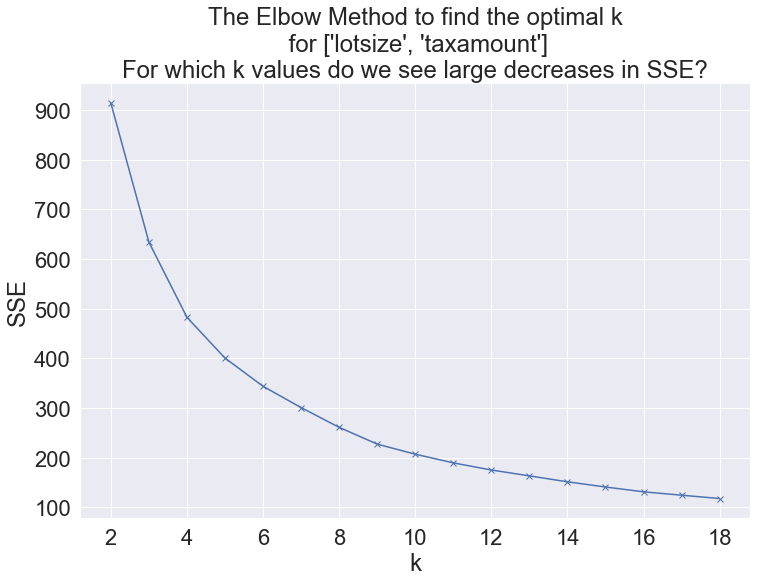

In [14]:
# create features for cluster
cluster_vars = ['lotsize','taxamount']

# scale data to be used in clustering
scaler = MinMaxScaler()
train[cluster_vars] = scaler.fit_transform(train[cluster_vars])
validate[cluster_vars] = scaler.transform(validate[cluster_vars])
test[cluster_vars] = scaler.transform(test[cluster_vars])

explore.find_k(train, cluster_vars)

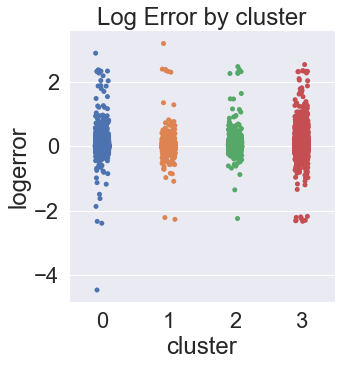

H0:  The logerrors are not significantly different
Ha:  The logerrors are significantly different
We confirm the Null Hypothesis


,lot_tax,centroid_lotsize,centroid_taxamount
0,0,0.269309,0.310431
1,1,0.327532,0.634634
2,2,0.673499,0.304809
3,3,0.273349,0.119937


In [15]:
# set k and name cluster
k=4
cluster_name = 'lot_tax'
# create clusters
kmeans3 = explore.create_clusters(train, k, cluster_vars)

X3_train = train.copy()
X3_train['cluster'] = kmeans3.predict(X3_train[cluster_vars])

explore.cluster_plot(X3_train)
explore.get_centroids(kmeans3, cluster_vars, cluster_name)

### These centroids show some significant groupings that can be used for modeling
    - Cluster 0 = littlelot_mediumprice
    - Cluster 1 = littlelot_highprice
    - Cluster 2 = largelot_mediumprice
    - Cluster 3 = littlelot_lowprice

## Rename clusters and append one-hot-encoded values to train, validate, and test

In [16]:
# call function to rename clusters, append to train/validate/test, and one-hot encode
train, validate, test = explore.add_clusters(kmeans3, train, validate, test, cluster_vars)

<div class="alert alert-block alert-success"><b><font size="+1">

# Takeaways from Data Exploration

- Location is significant, especially Los Angeles county
- Lot size can have a large impact on log error
- Explored clustering lat, long, taxes, garage size, and age.
    - moved forward with clusters using lotsize and taxamount

<hr style="border:10px solid blue">


## Modeling

In [17]:
# create modeling algorithms
OLS = LinearRegression(normalize=True)
LassoLars = LassoLars(alpha=1)

### Baseline Accuracy

In [18]:
#predict baseline using Mean and Median
results = modeling.predict_baseline(train)

,model,RMSE_train,RMSE_validate,R2
0,Mean,0.1634,N/A,N/A
1,Median,0.1639,N/A,N/A


<div class="alert alert-block alert-warning">

### Using the Mean, the baseline RMSE will be 0.1634


### Select Features 

In [19]:
features = [ 'bathrooms', 'bedrooms', 'sqft', 'latitude',
       'garagesqft', 'longitude', 'lotsize',
       'structuretaxvalue', 'landtaxvalue', 'taxamount', 'age',
       'dollarspersqft', 'Los Angeles', 'Orange', 'Ventura',
       'largelot_mediumprice', 'littlelot_highprice', 'littlelot_lowprice',
       'littlelot_mediumprice']

### Create X, y, and Scale


In [20]:
# create X and y
# create X and y sets
X_train = train[features]
y_train = train['logerror']

X_validate = validate[features]
y_validate = validate['logerror']

# scale data and save back to X
#scaler = MinMaxScaler()
X_train[features] = scaler.fit_transform(X_train[features])
X_validate[features] = scaler.transform(X_validate[features])

# OLS model

In [21]:
# send the OLS model to a function in the modeling.py file and append values to results table
newresult = modeling.LRmodel(OLS, X_train, y_train, X_validate, y_validate)
results.loc[len(results)] = newresult
results.tail(1)

,model,RMSE_train,RMSE_validate,R2
2,LinearRegression(normalize=True),0.1631,0.1690,0.0026


# LassoLars

In [22]:
# send the LassoLars model to a function in the modeling.py file and append values to results table
newresult = modeling.LRmodel(LassoLars, X_train, y_train, X_validate, y_validate)
results.loc[len(results)] = newresult
results.tail(1)

,model,RMSE_train,RMSE_validate,R2
3,LassoLars(alpha=1),0.1634,0.1692,-0.0003


## Use less features for two more models

In [23]:
# Select features for modeling
features2 = [ 'sqft', 'lotsize', 'regionidzip', 'age',
        'dollarspersqft', 'Los Angeles', 'Orange', 'Ventura']

# recreate X_train, X_validate, X_test
X_train = train[features2]
X_validate = validate[features2]

# scale data and save back to X
scaler = MinMaxScaler()
X_train[features2] = scaler.fit_transform(X_train[features2])
X_validate[features2] = scaler.transform(X_validate[features2])

# OLS (refined features)

In [24]:
# send the OLS model to a function in the modeling.py file and append values to results table
newresult = modeling.LRmodel(OLS, X_train, y_train, X_validate, y_validate)
results.loc[len(results)] = newresult
results.tail(1)

,model,RMSE_train,RMSE_validate,R2
4,LinearRegression(normalize=True),0.1632,0.1691,0.002


# LassoLars (refined features)

In [25]:
# send the LassoLars model to a function in the modeling.py file and append values to results table
newresult = modeling.LRmodel(LassoLars, X_train, y_train, X_validate, y_validate)
results.loc[len(results)] = newresult
results

,model,RMSE_train,RMSE_validate,R2
0,Mean,0.1634,N/A,N/A
1,Median,0.1639,N/A,N/A
2,LinearRegression(normalize=True),0.1631,0.1690,0.0026
3,LassoLars(alpha=1),0.1634,0.1692,-0.0003
4,LinearRegression(normalize=True),0.1632,0.1691,0.002
5,LassoLars(alpha=1),0.1634,0.1692,-0.0003


<div class="alert alert-block alert-warning"><b><font size="+1">

Model Comparison

All four models had better RMSE for training than for validate sets, indicating overtraining

We chose the OLS model because the R2 score was far better, and the version with the full feature set due to slightly better RMSE on the out of sample data

<hr style="border:10px solid blue">


# Testing the  Best Model

- Now testing the OLS model against our test data

In [26]:
# re-define features and scale
features3 = [ 'bathrooms', 'bedrooms', 'sqft', 'latitude',
       'garagesqft', 'longitude', 'lotsize',
       'structuretaxvalue', 'landtaxvalue', 'taxamount', 'age',
       'dollarspersqft', 'Los Angeles', 'Orange', 'Ventura',
       'largelot_mediumprice', 'littlelot_highprice', 'littlelot_lowprice',
       'littlelot_mediumprice']

# recreate X_train, X_validate, X_test (they are already scaled)
X_train = train[features3]
X_test = test[features3]

# scale data and save back to X
scaler = MinMaxScaler()
X_train[features3] = scaler.fit_transform(X_train[features3])
X_test[features3] = scaler.transform(X_test[features3])
y_test= test.logerror

In [27]:
# send the test set to the function in the modeling.py file.  The model is re-fit on the train data
newresult = modeling.LRmodel(OLS, X_train, y_train, X_test, y_test)
print('On Test Data:  RMSE:', newresult[2])
print('                 R2:', newresult[3])


On Test Data:  RMSE: 0.1742
                 R2: 0.0027


<div class="alert alert-block alert-success"><b><font size="+1">

## Testing Takeaways 
### RMS Error of 0.1742 on Out of Sample data failed to best baseline
    
- After testing four models we see evidence of overfitting
- Overfitting was confirmed on out of sample test data

<hr style="border:10px solid blue">



# Conclusions and Next Steps

- We found that Location, lot size, and value were drivers of Log Error

- We created a log error predictor that failed to beat baseline on the out of sample test data

- Clusters of lotsize and property value gave interesting categorization of properties

- Given more time for we would have tried to futher engineer features and clusters that were able to better predict log error since further insight was likely available in bedrooms, bathrooms, and regional data
